# Project: Food Vision Big TM

In [1]:
# Import libraries and checking using GPU
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:   
    print(f"GPU is available: {gpu_available}")
else:
    print("GPU is not available, using CPU instead.")

2025-07-06 11:34:13.335569: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 11:34:13.782617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751776453.954992     685 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751776453.993300     685 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751776454.356391     685 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!nvidia-smi

/bin/bash: /home/dikhang_hcmut/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Jul  6 11:34:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P8              2W /   60W |      66MiB /   6141MiB |      0%      Default |
|             

In Colab, they provide a GPU for free, so we can use it to train our model. But in this project, I decided to use my own GPU to train the model. The GPU is a NVIDIA GeForce RTX 4050.

And I have to mearsure that it's compatible with using mixed precision training...

## Get the helper functions


In [3]:
#!mkdir help_funcs && cd help_funcs && wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
# Import the helper functions
import sys
sys.path.append('help_funcs/')
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data

In [5]:
#!pip install tensorflow_datasets

## Import the dataset


In [6]:
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

2025-07-06 11:34:33.487337: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


True


In [9]:
(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    data_dir="datasets", # where to save the dataset
    with_info=True,
    as_supervised=True # data gets returned as tuple (image, label)
)

I0000 00:00:1751776542.824607     685 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### Exploring the dataset Food101
To become one with the dataset, let's explore it a bit.
* **Class names:** There are 101 classes in the dataset, each representing a different type of food.
* **Input data shape:** The shape of input data (image tensors): (None, None, 3) - The images can have different dimensions, but they all have 3 color channels (RGB).
* **Input data type:** : The images are represented as tensors with a data type of `tf.uint8`, which means they are unsigned 8-bit integers. That we have to convert to float32 for mixed precision training.
* The labels are represented as integers, where each integer corresponds to a specific class of food (e.g. one-hot encoded or label encoded).
* The matching up of the labels and images.

In [15]:
# Features of Food101 TFDS
ds_info.features

# Get the classnames
class_names = ds_info.features['label'].names
print(class_names[:10]) # print first 10 class names

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [17]:
# Output info about our training sample
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [18]:
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image dtype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 8
    Class name (str form): bread_pudding
    


2025-07-06 11:40:51.262123: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[18,  6,  8],
        [18,  6,  8],
        [18,  6,  8],
        ...,
        [30, 15, 22],
        [29, 14, 21],
        [26, 11, 18]],

       [[22, 10, 12],
        [21,  9, 11],
        [20,  8, 10],
        ...,
        [35, 20, 27],
        [31, 16, 23],
        [26, 11, 18]],

       [[23, 13, 14],
        [21, 11, 12],
        [19,  9, 10],
        ...,
        [39, 26, 33],
        [36, 21, 28],
        [30, 15, 22]],

       ...,

       [[15,  4,  8],
        [15,  4,  8],
        [14,  5, 10],
        ...,
        [41,  9, 10],
        [39,  7,  8],
        [36,  4,  5]],

       [[16,  5,  9],
        [16,  5,  9],
        [16,  5, 11],
        ...,
        [42, 12, 12],
        [39,  9,  9],
        [35,  5,  5]],

       [[15,  4,  8],
        [15,  4,  8],
        [16,  5, 11],
        ...,
        [41, 11, 11],
        [39,  9,  9],
        [35,  5,  5]]], dtype=uint8)>

In [20]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot the images from TFDS


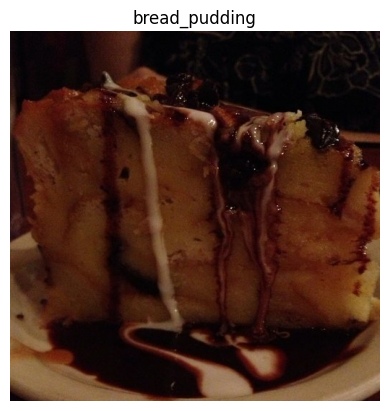

In [24]:
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Verify the label matches the image
plt.axis(False);

## Create preprocessing functions for our data

Because of the neural network architecture perform best when data is in a certain way (e.g. batched, normalized, resized, etc.)

In our model:
1. In `uint8` datatype.
2. Images are of different sizes.
3. Images are not normalized (pixel values range from 0 to 255).

We have to write a function to preprocess our data. This function will:
1. Convert the data type to `tf.float32` for mixed precision training.
2. For batches, resize the images to a specific size (e.g. 224x224).
3. Normalize the pixel values to a range of 0 to 1.


In [26]:

# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [23]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[18  6  8]
  [18  6  8]
  [18  6  8]
  ...
  [30 15 22]
  [29 14 21]
  [26 11 18]]

 [[22 10 12]
  [21  9 11]
  [20  8 10]
  ...
  [35 20 27]
  [31 16 23]
  [26 11 18]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[20.158163   8.158163  10.158163 ]
  [18.42347    7.6173472  9.020408 ]
  [15.010203   6.423469   9.285714 ]
  ...
  [26.285824  15.714351  23.07156  ]
  [31.091867  17.285728  24.285728 ]
  [28.754953  13.754952  20.754953 ]]

 [[18.92857    8.928571   9.928571 ]
  [16.214285   7.0765305  8.07653  ]
  [14.739796   8.571429  10.627552 ]
  ...
  [26.444029  15.872557  21.658293 ]
  [39.86226   26.862259  33.86226  ]
  [39.49479   24.494787  31.494787 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


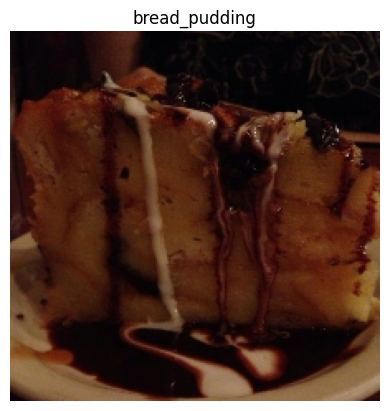

In [25]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batching and preparing our datasets
### Create a function to prepare the data

Specifically, we're going to be using:

1. `map()` - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
2. `shuffle()` - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
3. `batch()` - turns elements of a target dataset into batches (size defined by parameter batch_size)
4. `prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
Extra: `cache()` - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:

* Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
* `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)

* For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to `num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
* Can't use `cache()` unless your dataset can fit in memory

We're going to through things in the following order:

> `Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset`

This is like saying,

*"Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".*

In [27]:
# Mapping our preprocessing function to the training data
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the training data and turn it into batches and prefectch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to the test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn then test data into batches and prefetch it
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:

train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks
To do each of these we'll use the following callbacks:

1. `tf.keras.callbacks.TensorBoard()` - allows us to keep track of our model's training history so we can inspect it later (note: we've created this callback before have imported it from helper_functions.py as `create_tensorboard_callback())`
2. `tf.keras.callbacks.ModelCheckpoint()` - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
*   Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [30]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save our model's progress
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_accuracy",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=0)

## Setup mixed precision training
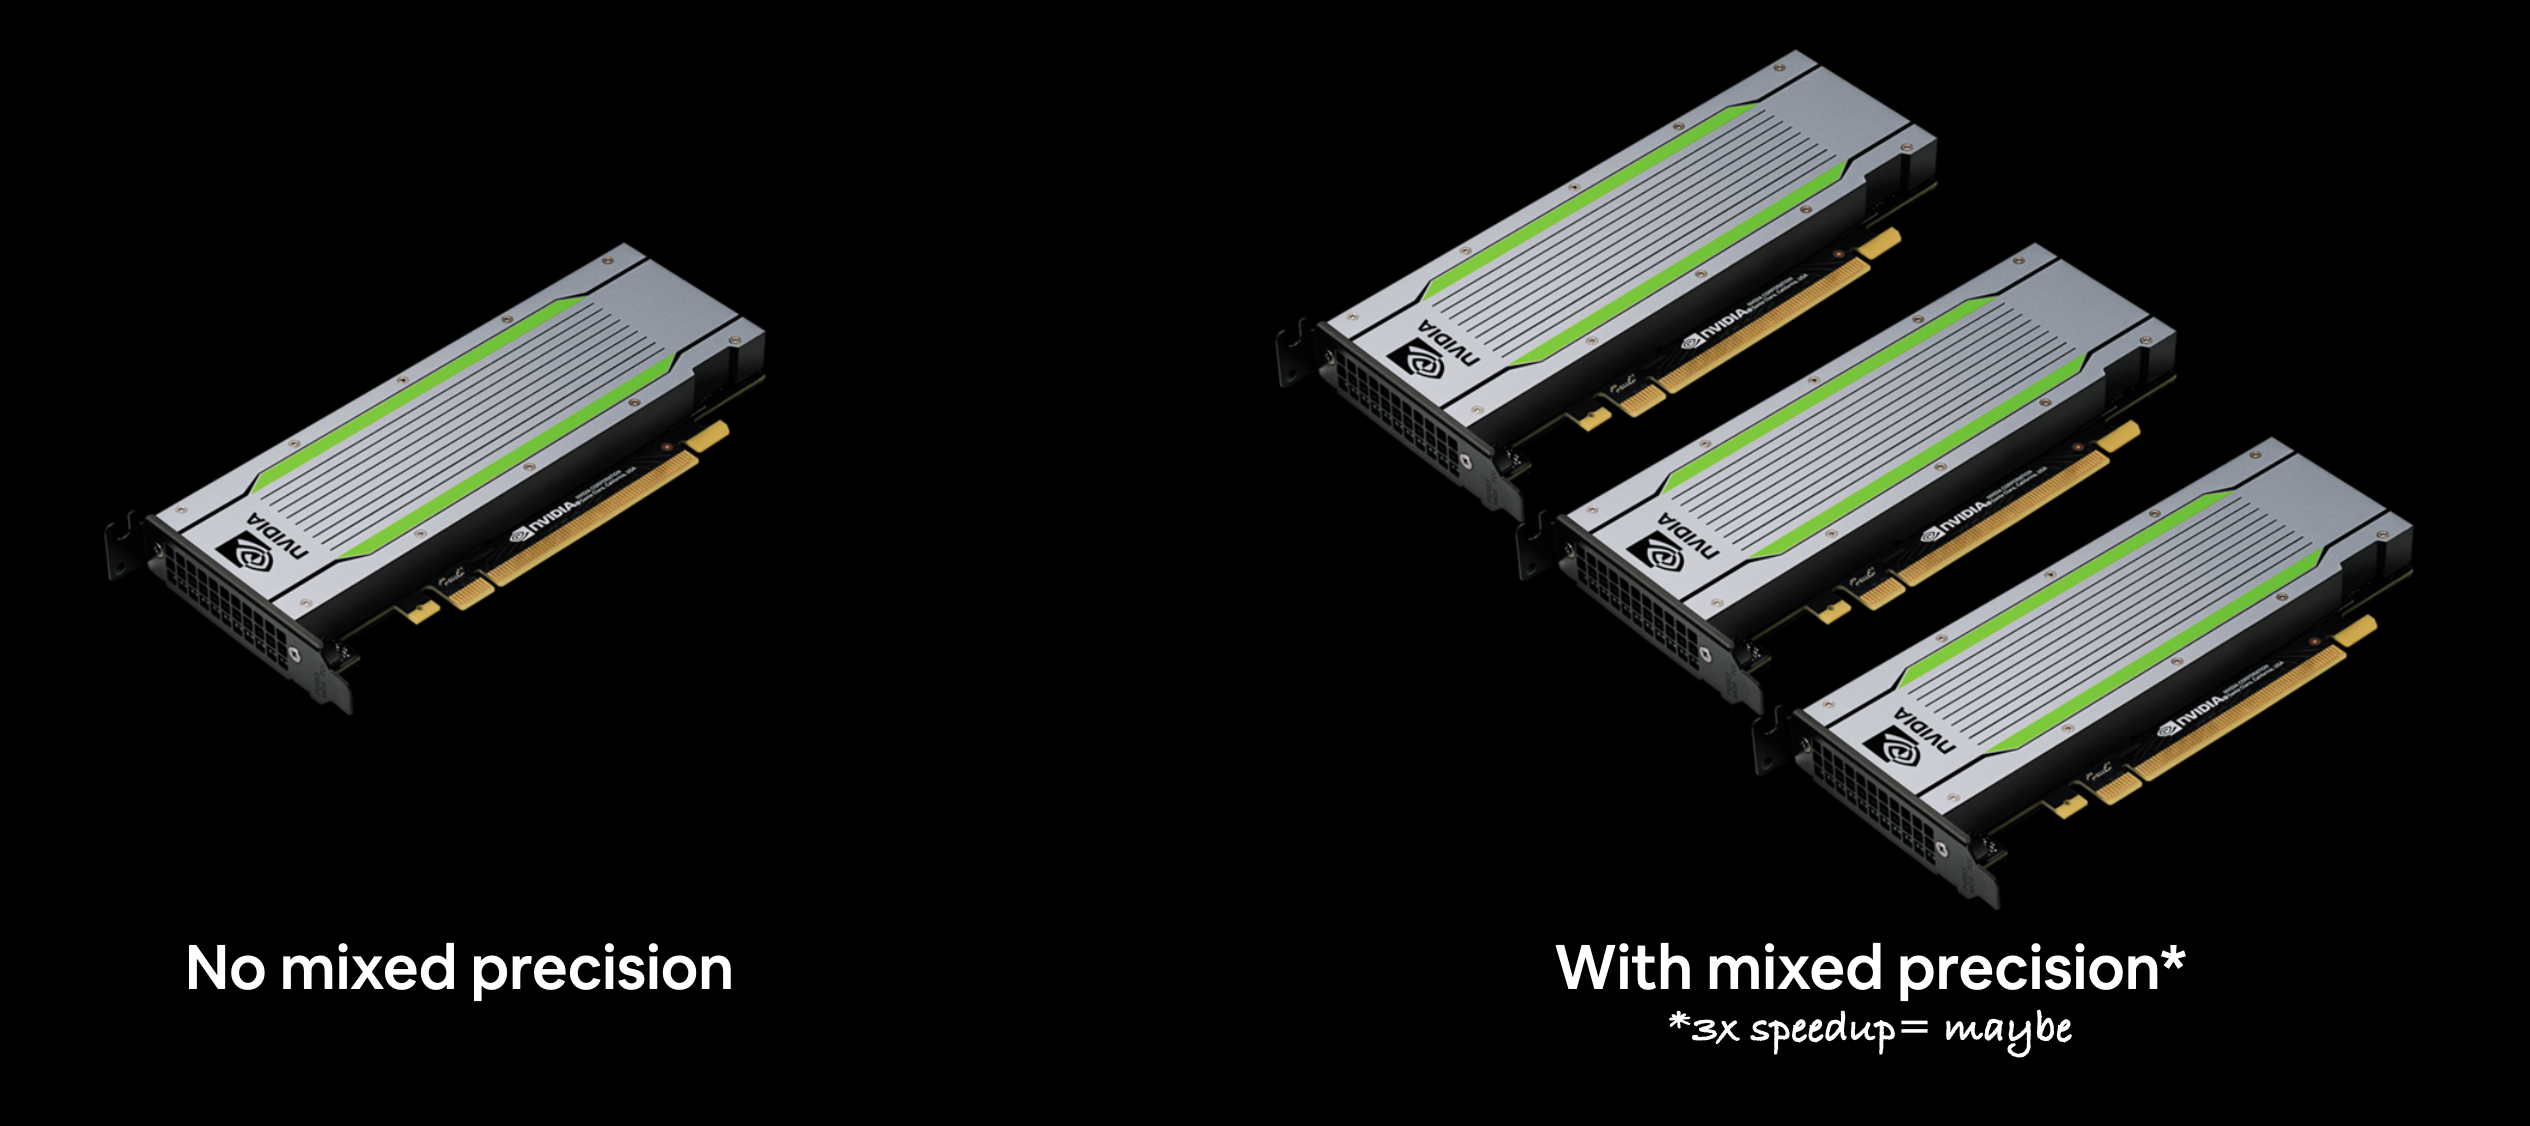

In [31]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") 

In [32]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

"mixed_float16" our model will automatically take advantage of float16 variables where possible and in turn speed up training.